# Данная работала выполнялась в рамках лабораторной работы по учебной дисциплине глубокое обучение в магистратуре

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from seaborn import heatmap
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import seaborn as sns

# Реализация обучения модели происходила не на основе готовой модели
## Обучение модели на определение сердечных проблем на основе следующих данных:
* gender,
* ever_married,
* work_type,
* Residence_type,
* smoking_status.

## Чтобы получить более точный результат требовалось разработать модель с нуля

## Поэтому был реализован собственный классы:
* CustomTensorDataset
* NeuralNetwork




In [ ]:
df = pd.read_csv(r'D:\Загрузки\healthcare-dataset-stroke-data.csv')


In [ ]:
df.fillna((df.mean()), inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_2416\491377160.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna((df.mean()), inplace=True)


In [ ]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


#### Подготовка данных для обучения

In [ ]:
class Myclass:
    def create_Category_columns(self, df, column):
        unique_values = df[column].unique()
        for value in unique_values:
            df[value] = df[column].apply(lambda x: 1 if x == value else 0)


In [ ]:
p1 = Myclass()

In [ ]:
p1.create_Category_columns(df, 'gender')

In [ ]:
p1.create_Category_columns(df, 'work_type')


In [ ]:
p1.create_Category_columns(df, 'Residence_type')

In [ ]:
p1.create_Category_columns(df, 'smoking_status')

In [ ]:
p1.create_Category_columns(df, 'ever_married')

In [ ]:
df = df.drop(['id','gender','ever_married','work_type','Residence_type','smoking_status'],axis=1)

In [ ]:
column_names=df.columns.to_list()

#### Перетасовка данных

In [ ]:
from sklearn import preprocessing

x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled,columns=column_names)

In [ ]:
from imblearn.over_sampling import SMOTE
import torch.optim as optim

#### Разработка классов для обучения модели

In [ ]:
class CustomTensorDataset(Dataset):
    def __init__(self, *tensors):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Размеры тензоров должны быть одинаковыми"
        self.tensors = tensors

    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bt = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,hidden_size*3)
        self.bt2 = nn.BatchNorm1d(hidden_size*3)
        self.fc3= nn.Linear(hidden_size*3,output_size)
#         self.bt3 = nn.BatchNorm1d(hidden_size)
#         self.fc4= nn.Linear(hidden_size,output_size)




    def forward(self, x):
        out = self.fc1(x)
        out = self.bt(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bt2(out)
        out = self.relu(out)
        out = self.fc3(out)
#         out = self.bt3(out)
#         out = self.relu(out)
#         out = self.fc4(out)
        return out

In [ ]:
X = df.drop(['stroke'], axis=1)
y = df['stroke']
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train, y_train)

#### Распределение данных для обучения и валидации

In [ ]:
x_train_tensor = torch.from_numpy(x_train.values).float()
y_train_tensor = torch.from_numpy(y_train.values).long()
x_validation_tensor = torch.from_numpy(x_validation.values).float()
y_validation_tensor = torch.from_numpy(y_validation.values).long()

#### Указываем настроки для обучения модели

In [ ]:
input_size = x_train_tensor.shape[1]
hidden_size = 64
output_size = 2
batch_size = 64
learning_rate = 0.00001
num_epochs = 100

In [ ]:
train_dataset = CustomTensorDataset(x_train_tensor, y_train_tensor)
validation_dataset = CustomTensorDataset(x_validation_tensor, y_validation_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Обучение модели

In [ ]:
train_losses = []
validation_losses = []
validation_accuracies = []

# Обучение модели
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in validation_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        validation_loss /= len(validation_dataloader)
        validation_accuracy = 100 * correct / total
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

    print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}, Validation Loss: {:.4f}%'.format(epoch+1, num_epochs, train_loss, validation_accuracy, validation_loss))

Epoch [1/100], Loss: 0.6715, Validation Accuracy: 63.21, Validation Loss: 0.6684%
Epoch [2/100], Loss: 0.6408, Validation Accuracy: 66.83, Validation Loss: 0.6279%
Epoch [3/100], Loss: 0.6176, Validation Accuracy: 64.48, Validation Loss: 0.6178%
Epoch [4/100], Loss: 0.5998, Validation Accuracy: 65.26, Validation Loss: 0.5976%
Epoch [5/100], Loss: 0.5851, Validation Accuracy: 66.73, Validation Loss: 0.5776%
Epoch [6/100], Loss: 0.5715, Validation Accuracy: 64.77, Validation Loss: 0.5845%
Epoch [7/100], Loss: 0.5619, Validation Accuracy: 66.83, Validation Loss: 0.5617%
Epoch [8/100], Loss: 0.5515, Validation Accuracy: 66.34, Validation Loss: 0.5637%
Epoch [9/100], Loss: 0.5441, Validation Accuracy: 65.95, Validation Loss: 0.5613%
Epoch [10/100], Loss: 0.5367, Validation Accuracy: 64.38, Validation Loss: 0.5686%
Epoch [11/100], Loss: 0.5281, Validation Accuracy: 66.93, Validation Loss: 0.5444%
Epoch [12/100], Loss: 0.5219, Validation Accuracy: 67.81, Validation Loss: 0.5381%
Epoch [13/100

Epoch [100/100], Loss: 0.3566, Validation Accuracy: 77.98, Validation Loss: 0.4078%


#### Графики обучения на тренировачных и тестовых данных, а также отдельных график, который показывает как происходит распознование при валидации

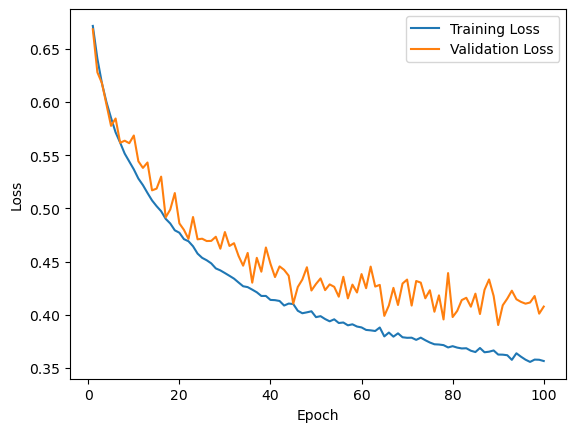

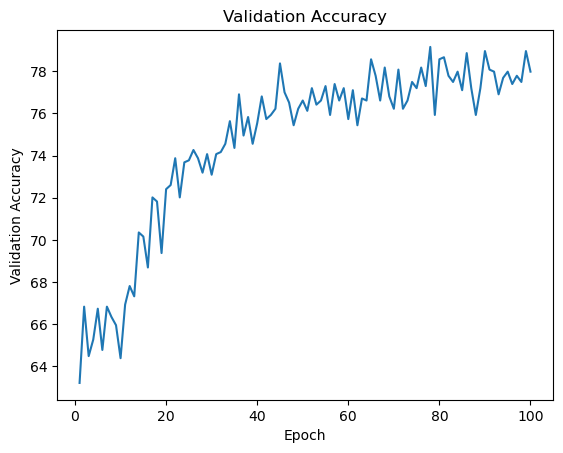

In [ ]:
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1, num_epochs+1), validation_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

#### Проверяем на количество ошибок

In [ ]:
model.eval()
with torch.no_grad():
    validation_predictions = []
    for inputs, labels in validation_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        validation_predictions.extend(predicted.tolist())
    confusion_matrix = np.zeros((output_size, output_size), dtype=int)
    for i in range(len(validation_predictions)):
        confusion_matrix[y_validation_tensor[i].item(), validation_predictions[i]] += 1

print('Матрица ошибок:')
print(confusion_matrix)


Матрица ошибок:
[[757 203]
 [ 22  40]]
